In [1]:
from data import Data
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from utils import timestamp
from bo import BOArchitecture
import math

In [2]:
# This is customizable
seed = 50 # random seed to guarantee reproducibility of results
OPT_K = 50 # number of K in Kmeans clustering
BREED_LEN = 5 # number of perspective patterns to explore during BO stage
SIMILARITY_TOLERANCE = 0.9 # probability level that defines if element constructs a pattern;
BATCH_SIZE = 500
# This is not customizable
MAX_VERTICES = 7 # NOT A HYPERPARAMETER; This is a nasbench setting
MAX_EDGES = 9 # NOT A HYPERPARAMETER; This is a nasbench setting

In [3]:
dt = Data(seed)

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 87 seconds


In [4]:
df, random_cells, random_results = dt.query_batch(BATCH_SIZE)

  0%|          | 1/500 [00:00<01:05,  7.58it/s]

I01DT: Collecting unique architectures


 14%|█▎        | 68/500 [00:00<00:01, 332.86it/s]

I02DT: Evaluating unique architectures


100%|██████████| 500/500 [00:01<00:00, 335.73it/s]

I03DT: Saving log df of observations
I04DT: Plotting observed data


In [5]:
df

,trainable_parameters,training_time,train_accuracy,validation_accuracy,test_accuracy
hash,,,,,
5590763001445364168,12945034,2096.432129,1.0000,0.933093,0.933694
7829740710916887463,12508170,1926.893066,0.9999,0.912460,0.909756
-271653988647509190,5755750,1578.025024,1.0000,0.936498,0.934195
5309054960611893317,49105546,5186.331055,1.0000,0.940405,0.934696
-211962829862576936,13381898,2241.419922,1.0000,0.936599,0.937200
...,...,...,...,...,...
-7379628590043878775,5480301,1425.905029,1.0000,0.911458,0.905449
4776024372385055184,48231818,4904.451172,0.9999,0.909856,0.903946
-7756128896245020584,12508170,1969.707031,1.0000,0.925881,0.922075


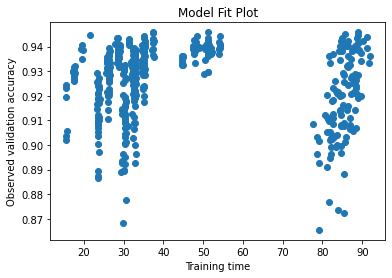

In [6]:
fig, ax = plt.subplots()
ax.scatter(df['training_time'] / 60, df['validation_accuracy'])
ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed validation accuracy')
ax.set_xlabel('Training time');

In [7]:
# similarities = np.zeros((df.shape[0], df.shape[0]))

# i = 0
# for h1 in tqdm(df.index):
#     j = 0
#     for h2 in df.index:
#         if h1 != h2:
#             matrix1 = np.asarray(random_cells[str(h1)]['matrix'])
#             matrix2 = np.asarray(random_cells[str(h2)]['matrix'])
#             similarities[i][j] = np.count_nonzero(
#                 (matrix1 + matrix2) == 2 # to filter out lower triangular similarity
#             )
#         j += 1
#     i += 1

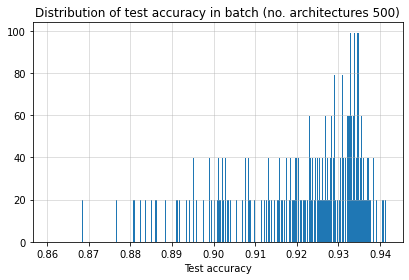

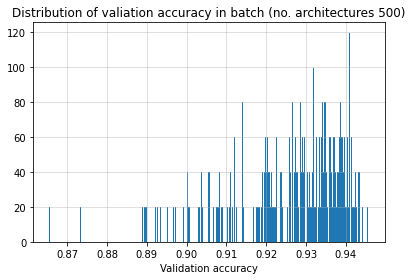

In [8]:
dt.plot_data(df)

In [9]:
cell_structures = [np.asarray(random_cells[str(h)]['matrix']).reshape(-1) for h in df.index]
sum_of_squared_distances = []
K = range(1,300)
cell_structures
# for k in tqdm(K):
#     km = KMeans(n_clusters=k, random_state = seed)
#     km = km.fit(cell_structures)
#     sum_of_squared_distances.append(km.inertia_)

# plt.plot(K, sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum of squared distances')
# plt.title('Elbow Method For Optimal k')
# t = timestamp()
# plt.savefig('figures/sum_of_squares' + str(t) + '.pdf', dpi=600)
# plt.show()

[array([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0]),
 array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0]),
 array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0]),
 array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0]),
 array([0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0]),
 array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

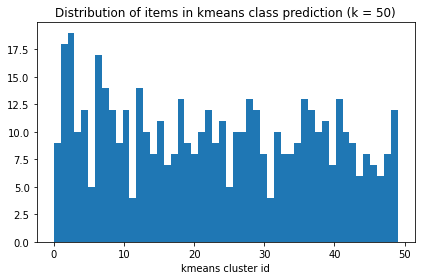

In [10]:
# Below default OPT_K is 50; This is not optimal, but since we are limited with budget of initial sample
# we are good with having this number this small - for more details, refer to thesis
# This value should be treated as a hyperparameter
km = KMeans(n_clusters=OPT_K, random_state = seed)
km = km.fit(cell_structures)
predicted_k = km.predict(cell_structures)

t = timestamp()
plt.figure()
plt.title('Distribution of items in kmeans class prediction (k = {})'.format(OPT_K))
plt.hist(predicted_k, bins=OPT_K)
plt.xlabel('kmeans cluster id')
#plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.savefig('figures/kmeans_class_dist' + str(t) + '.pdf', dpi=600)
plt.show()

In [11]:
df['class'] = predicted_k

In [12]:
def rank_column(x):
    return [math.floor(i * 10 / OPT_K) for i in stats.rankdata(x, "average")]

In [13]:
by_class = df\
    .groupby(['class'])['test_accuracy', 'validation_accuracy', 'training_time']\
    .agg(['mean', 'std'])

by_class['test_accuracy_rank'] = rank_column(by_class['test_accuracy']['mean'])
by_class['training_time_rank'] = rank_column(by_class['training_time']['mean'])

by_class = by_class.sort_values(['test_accuracy_rank', 'training_time_rank'], ascending=[False, True])
breed = by_class[by_class.training_time_rank.le(3)].head(BREED_LEN).index.to_numpy()
# We are not interested in high computation time
# Thats why we filter out training_time_rank > 3
breed

/Users/volodymyr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


array([11, 41,  9, 25, 31])

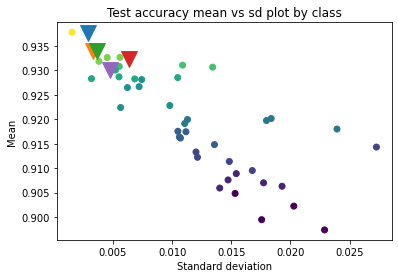

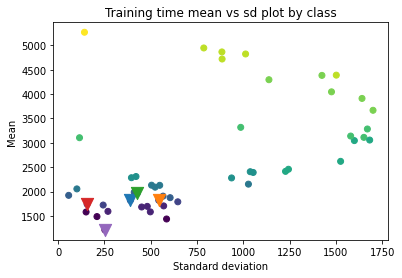

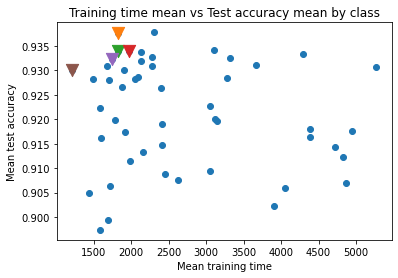

In [14]:
fig, ax = plt.subplots()
ax.scatter(by_class['test_accuracy']['std'],
           by_class['test_accuracy']['mean'],
           c=by_class['test_accuracy_rank']
)
for b in breed:
    ax.scatter(
        by_class.loc[b]['test_accuracy']['std'],
        by_class.loc[b]['test_accuracy']['mean'],
        marker = "v",
        s = 250
    )
ax.set_title('Test accuracy mean vs sd plot by class')
ax.set_ylabel('Mean')
ax.set_xlabel('Standard deviation');
plt.savefig('figures/kmeans_test_mean_sd' + str(t) + '.pdf', dpi=600)
plt.show()

fig, ax = plt.subplots()
ax.scatter(by_class['training_time']['std'], by_class['training_time']['mean'], c=by_class['training_time_rank'])
for b in breed:
    ax.scatter(
        by_class.loc[b]['training_time']['std'],
        by_class.loc[b]['training_time']['mean'],
        marker = "v",
        s = 150
    )
ax.set_title('Training time mean vs sd plot by class')
ax.set_ylabel('Mean')
ax.set_xlabel('Standard deviation');
plt.savefig('figures/kmeans_training_time_mean_sd' + str(t) + '.pdf', dpi=600)
plt.show()

fig, ax = plt.subplots()
ax.scatter(by_class['training_time']['mean'], by_class['test_accuracy']['mean'])
for b in breed:
    ax.scatter(
        by_class.loc[b]['training_time']['mean'],
        by_class.loc[b]['test_accuracy']['mean'],
        marker = "v",
        s = 150
    )
ax.set_title('Training time mean vs Test accuracy mean by class')
ax.set_ylabel('Mean test accuracy')
ax.set_xlabel('Mean training time');
plt.savefig('figures/kmeans_training_time_test_acc_mean' + str(t) + '.pdf', dpi=600)
plt.show()

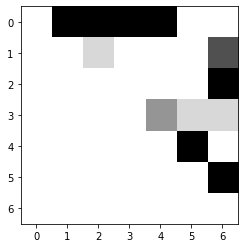

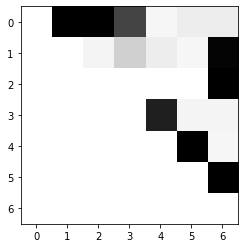

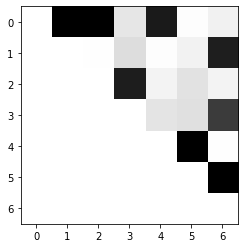

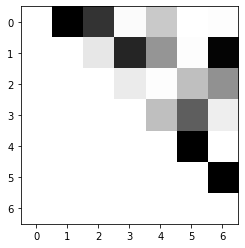

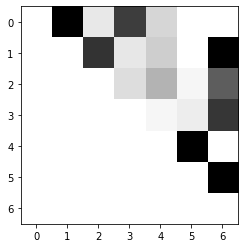

In [15]:
empty_cell = np.zeros((MAX_VERTICES, MAX_VERTICES))
probability_maps = []
for b in breed:
    samples = df[df['class'].eq(b)].index
    heatmap = empty_cell
    for s in samples:
        heatmap += np.asarray(random_cells[str(s)]['matrix'])
    heatmap /= np.amax(heatmap, axis=None)
    plt.imshow(heatmap, cmap="Greys")
    plt.show()
    probability_maps.append((heatmap > SIMILARITY_TOLERANCE) * 1)  # Remove values that are lower than tolerance level

/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


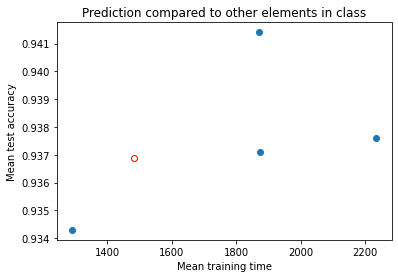

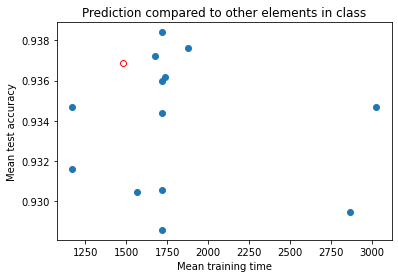

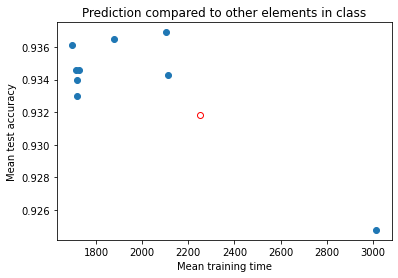

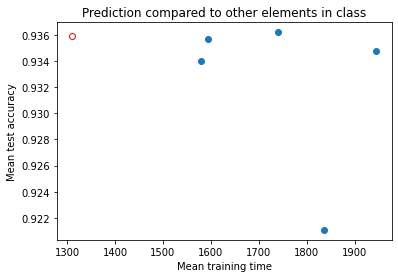

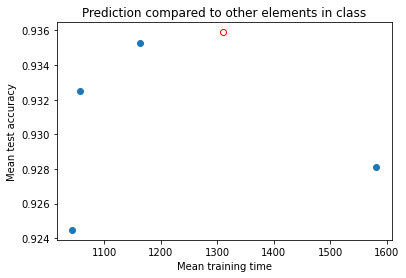

In [16]:
results_acc = []
results_tt = []
optimal_score = []
train_budget = dt.nb.get_budget()[0]
dt.nb.reset_budget()
tr_params = []
for i in range(0, BREED_LEN):
    class_subset = df[df['class'].eq(breed[i])]
    bo = BOArchitecture(probability_maps[i], np.max(class_subset['training_time']), dt.nb, seed)
    bo.optimize_architecture()
    #bo.plot_convergence()
    d, a = bo.get_best_result()
    fig, ax = plt.subplots()
    mean_acc = np.sum([el['final_test_accuracy'] for el in a[108]]) / len(a[108])
    mean_tt = np.sum([el['final_training_time'] for el in a[108]]) / len(a[108])
    results_acc.append(mean_acc)
    results_tt.append(mean_tt)
    tr_params.append(d['trainable_parameters'])
    optimal_score.append(mean_acc / mean_tt)
    ax.scatter(class_subset['training_time'], class_subset['test_accuracy'])
    ax.plot(
        np.sum([el['final_training_time'] for el in a[108]]) / len(a[108]),
        np.sum([el['final_test_accuracy'] for el in a[108]]) / len(a[108]),
        marker = "o",
        markerfacecolor="None",
        markeredgecolor='red',
        markeredgewidth=1
    )
    ax.set_title('Prediction compared to other elements in class')
    ax.set_ylabel('Mean test accuracy')
    ax.set_xlabel('Mean training time');
    plt.savefig('figures/kmeans_training_time_test_acc_mean' + str(t) + '.pdf', dpi=600)
    plt.show()
    #print(d['test_accuracy'] - np.max(df[df['class'].eq(breed[i])]['test_accuracy']))
    #print(d['training_time'] - np.min(df[df['class'].eq(breed[i])]['training_time']))

1310.4569498697917 0.9358974496523539 7857930


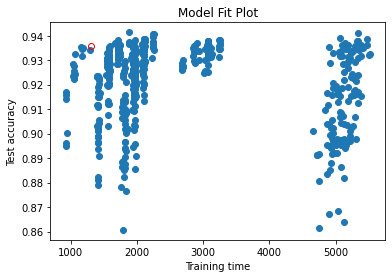

<Figure size 432x288 with 0 Axes>

In [17]:
fig, ax = plt.subplots()
ax.scatter(df['training_time'], df['test_accuracy'])
ax.set_title('Model Fit Plot')
ax.set_ylabel('Test accuracy')
ax.set_xlabel('Training time');
i = optimal_score.index(max(optimal_score))
print(results_tt[i], results_acc[i], tr_params[i])
ax.plot(
    results_tt[i],
    results_acc[i],
    marker = "o",
    markerfacecolor="None",
    markeredgecolor='red',
    markeredgewidth=1
)
plt.show()
plt.savefig('figures/result' + str(t) + '.pdf', dpi=600)

In [18]:
df.shape

(500, 6)

In [19]:
dt.nb

In [21]:
train_budget

1360558.5917358398

In [ ]:
seed


In [ ]:
a

In [ ]:
[1325.6982828776042, 1325.6982828776042, 1325.6982828776042, 1325.6982828776042, 1325.6982828776042, 1325.6982828776042, 1325.6982828776042]
[0.9345619678497314, 0.9345619678497314, 0.9345619678497314, 0.9345619678497314, 0.9345619678497314, 0.9345619678497314, 0.9345619678497314]
[0.9317908684412638, 0.9317908684412638, 0.9317908684412638, 0.9317908684412638, 0.9317908684412638, 0.9317908684412638, 0.9317908684412638]
[351690.5831298828, 351690.5831298828, 351690.5831298828, 351690.5831298828, 351690.5831298828, 351690.5831298828, 351690.5831298828]
[2786143.207397461, 2786143.207397461, 2786143.207397461, 2786143.207397461, 2786143.207397461, 2786143.207397461, 2786143.207397461]
[38936714, 38936714, 38936714, 38936714, 38936714, 38936714, 38936714]